In [1]:
import sys
sys.path.append('./.local/lib/python3.8/site-packages')
sys.path.append('/usr/lib/python3/dist-packages')

from tqdm import tqdm
from keras import losses, metrics
from keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold
#from keras.utils.training_utils import multi_gpu_model


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
GPU = 1
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]= f"{GPU}"  

print(datetime.datetime.now())

2023-09-22 15:27:14.301660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 15:27:15.029644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cuda_nvrtc/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cudnn/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cublas/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/python3.8/site-packages/nvidia/cudnn/lib:/opt/anaconda-3-2020.02/envs/hskim/lib/:/usr/local/cudnn-112-81133/lib64:/u

2023-09-22 15:27:16.416832


In [2]:
def ECG_filter(seg, method, srate):
    if method == 'bandpass':
        import scipy.signal
        sos = scipy.signal.butter(3, [1,47], 'bandpass', output='sos', fs=srate)
        return scipy.signal.sosfilt(sos, seg)
    # lowess랑 수학적으로 동일한데 더 빠름 - 대신 계수 체크 필요
    elif method == 'savgol':
        import scipy.signal
        return seg - scipy.signal.savgol_filter(seg, 1151, 3)
    
    elif method == 'lowess':
        import statsmodels.api as sm
        x = np.arange(0, len(seg))
        return seg - sm.nonparametric.lowess(seg, x, frac=0.2, it=0)[:, 1].T

    else:
        print('not a valid filter')
        return seg

In [39]:
from keras.models import model_from_json


def best_model(models_dir, adult, gender):
    #hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{adult}_{gender}_{TRAIN}'
    #models_dir = f"randomSearch/{hyper_path}/CNN_4layers_{nfold}fold_test{ntest}"
    model_list = np.array(os.listdir(models_dir))
    
    mask = [(True if ('mae' in path) else False) for path in model_list]
    model_list = model_list[mask]
    
    perf_list = [float(path.split('_',1)[0][3:]) for path in model_list]
    best_model_path = model_list[np.argmin(perf_list)]
    
    print(f'{adult}-{gender}-best model: {best_model_path}')
    
    load_path = f'{models_dir}/{best_model_path}'
    with open(load_path+"/model.json", 'r') as f_json:
        loaded_model_json = f_json.read()
        
    loaded_model = model_from_json(loaded_model_json)
    load_weight_path = load_path+'/weights.hdf5'
    loaded_model.load_weights(load_weight_path)
    return loaded_model



SRATE = 500
ECG_FILT = 'bandpass'
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'
GENDER = 'male'

hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
input_path = f'dataset/{hyper_path}/'

nfold = 4 
ntest = 500
rootdir = f"randomSearch/{hyper_path}/CNN_4layers_{nfold}fold_test{ntest}"

# loading best model in rootdir
ADULT = 'adult'
GENDER = 'male'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/best_model/{hyper_path}'
model_adult_male = best_model(rootdir, ADULT, GENDER)

ADULT = 'adult'
GENDER = 'female'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/best_model/{hyper_path}'
model_adult_female = best_model(rootdir, ADULT, GENDER)

ADULT = 'child'
GENDER = 'male'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/best_model/{hyper_path}'
model_child_male = best_model(rootdir, ADULT, GENDER)

ADULT = 'child'
GENDER = 'female'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
rootdir = f'randomSearch/best_model/{hyper_path}'
model_child_female = best_model(rootdir, ADULT, GENDER)

adult-male-best model: mae7.52_lr0.001_drop0.3_epochs_drop5_decay0.0001_mae
adult-female-best model: mae7.31_mae7.60+-_batch32_lr0.001_drop0.4_epochs_drop5_decay1e-4_mse
child-male-best model: mae0.53_lr0.001_drop0.4_epochs_drop5_decay0.0001_mae
child-female-best model: mae0.55_lr0.001_drop0.4_epochs_drop5_decay0.0001_mae


### input: signals

In [23]:
SRATE = 500
TRAIN = 'valid'
ADULT = 'adult'
NORM = 'z-norm'
LEADS = np.arange(12)
ECG_FILT = 'bandpass'

df_sub = pd.read_csv(f'submission.csv')
for idx, row in tqdm(df_sub.iterrows(), total=df_sub.shape[0]):
    if 'adult' in row['FILENAME']:
        ADULT = 'adult'
        model = model_adult_male if row['GENDER'] == 'MALE' else model_adult_female

        
    else:
        ADULT = 'child'
        model = model_child_male if row['GENDER'] == 'MALE' else model_child_female
          
    file_path = f'dataset/ECG_{ADULT}_numpy_valid'
    caseid = row['FILENAME']
    
    seg_ecg = np.load(f'{file_path}/{caseid}.npy')
    seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
    
    # invalid ecg
    if len(np.unique(seg_ecg)) == 1:
        df_sub.loc[idx, 'AGE'] = 65 if ADULT == 'adult' else 4
        continue
    
    # NORM = z-norm
    ecg_input = []
    for i in LEADS:
        ecg_input.append(stats.zscore(seg_ecg[5000*i:5000*(i+1)]))
        
    if ADULT == 'adult':
        df_sub.loc[idx, 'AGE'] = model.predict(np.array(ecg_input).reshape(1,12,5000).transpose((0,2,1)), verbose=0).flatten()[0] * 100
    else:
        df_sub.loc[idx, 'AGE'] = model.predict(np.array(ecg_input).reshape(1,12,5000).transpose((0,2,1)), verbose=0).flatten()[0] * 20

100%|██████████| 5475/5475 [09:00<00:00, 10.13it/s]


In [24]:
import pandas as pd

#df_subm = pd.read_csv('submission_dl.csv')
for idx, row in df_sub.iterrows():
    if row['AGE'] < 0:
        df_sub.loc[idx, 'AGE'] = 0
df_sub.to_csv('submission_dl.csv')

df_sub

,FILENAME,GENDER,AGE
0,ecg_child_8781,FEMALE,0.612833
1,ecg_child_8782,MALE,2.628800
2,ecg_child_8783,MALE,2.421709
3,ecg_child_8784,FEMALE,3.958093
4,ecg_child_8785,FEMALE,1.143933
...,...,...,...
5470,ecg_adult_39536,FEMALE,43.767059
5471,ecg_adult_39537,FEMALE,63.392931
5472,ecg_adult_39538,FEMALE,55.300808
5473,ecg_adult_39539,FEMALE,56.270349


In [25]:
df_sub.to_csv('submission_dl.csv')

### input: signals + features

In [71]:
SRATE = 500
TRAIN = 'valid'
ADULT = 'adult'
NORM = 'z-norm'
LEADS = np.arange(12)
ECG_FILT = 'bandpass'

df_sub = pd.read_csv(f'submission.csv')
for idx, row in tqdm(df_sub[:].iterrows(), total=df_sub.shape[0]):
    if 'adult' in row['FILENAME']:
        ADULT = 'adult'
        model = model_adult_female if row['GENDER'] == 'FEMALE' else model_adult_male
        x_feature = x_feature_adult_f if row['GENDER'] == 'FEMALE' else x_feature_adult_m
        caseids = caseid_adult_f if row['GENDER'] == 'FEMALE' else caseid_adult_m
        SCALE_Y = 100
    else:
        ADULT = 'child'
        model = model_child_female if row['GENDER'] == 'FEMALE' else model_child_male
        x_feature = x_feature_child_f if row['GENDER'] == 'FEMALE' else x_feature_child_m
        caseids = caseid_child_f if row['GENDER'] == 'FEMALE' else caseid_child_m
        SCALE_Y = 20
            
    file_path = f'dataset/ECG_{ADULT}_numpy_valid'
    caseid = row['FILENAME']
    
    seg_ecg = np.load(f'{file_path}/{caseid}.npy')
    seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
    
    # invalid ecg
    if len(np.unique(seg_ecg)) == 1:
        df_sub.loc[idx, 'AGE'] = 65 if ADULT == 'adult' else 4
        continue
    
    # NORM = z-norm
    ecg_input = []
    for i in LEADS:
        ecg_input.append(stats.zscore(seg_ecg[5000*i:5000*(i+1)]))

  
    feat = x_feature[caseids==caseid]
    if len(feat)==0:
        print('no match', caseid)
        df_sub.loc[idx, 'AGE'] = 65 if ADULT == 'adult' else 4
        continue
        #break
    feat = feat[0]

    
    df_sub.loc[idx, 'AGE'] = model.predict([np.array(ecg_input).reshape(1,12,5000).transpose((0,2,1)), feat.reshape(1,55)], verbose=0).flatten()[0] * SCALE_Y
            


 10%|▉         | 532/5475 [00:52<05:16, 15.64it/s]

no match ecg_child_9310


 35%|███▍      | 1899/5475 [03:01<05:35, 10.66it/s]

no match ecg_adult_35940


 46%|████▌     | 2517/5475 [04:03<03:33, 13.88it/s]

no match ecg_adult_36566


100%|██████████| 5475/5475 [08:49<00:00, 10.35it/s]


In [72]:
import pandas as pd

#df_subm = pd.read_csv('submission_dl.csv')
for idx, row in df_sub.iterrows():
    if row['AGE'] < 0:
        df_sub.loc[idx, 'AGE'] = 0
df_sub.to_csv('submission_dl.csv')

df_sub

,FILENAME,GENDER,AGE
0,ecg_child_8781,FEMALE,0.518545
1,ecg_child_8782,MALE,4.841044
2,ecg_child_8783,MALE,2.911650
3,ecg_child_8784,FEMALE,5.333902
4,ecg_child_8785,FEMALE,0.557445
...,...,...,...
5470,ecg_adult_39536,FEMALE,33.181503
5471,ecg_adult_39537,FEMALE,60.056990
5472,ecg_adult_39538,FEMALE,45.596287
5473,ecg_adult_39539,FEMALE,59.301108


(array([1.100e+03, 1.000e+00, 5.000e+01, 2.040e+02, 3.090e+02, 3.530e+02,
        5.450e+02, 1.339e+03, 1.308e+03, 2.660e+02]),
 array([3.10494588e-02, 8.54525394e+00, 1.70594584e+01, 2.55736629e+01,
        3.40878674e+01, 4.26020719e+01, 5.11162763e+01, 5.96304808e+01,
        6.81446853e+01, 7.66588898e+01, 8.51730943e+01]),
 <a list of 10 Patch objects>)

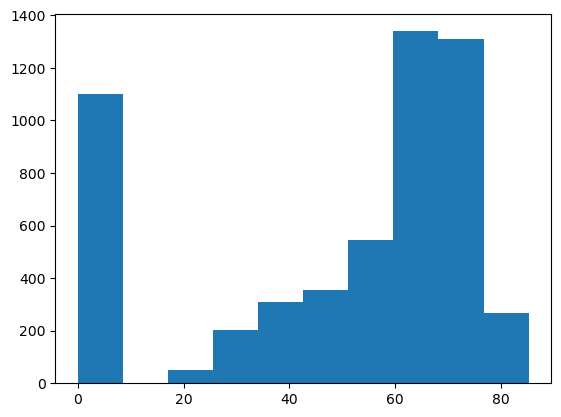

In [73]:
plt.hist(df_sub['AGE'].tolist())

### features loading

In [12]:
SRATE = 500
ECG_FILT = 'bandpass'
ADULT = 'child'
NORM = 'z-norm'

GENDER = 'male'
TRAIN = 'final'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_child_m = f['caseid']
    x_feature_child_m = f['X_feature']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_child_m.shape}') #, signal {x_signal_child_m.shape}')


GENDER = 'female'
TRAIN = 'final'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_child_f = f['caseid']
    x_feature_child_f = f['X_feature']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_child_f.shape}') #, signal {x_signal_f.shape}')

child_final_male
feature (589, 55)
child_final_female
feature (510, 55)


In [13]:
SRATE = 500
ECG_FILT = 'bandpass'
ADULT = 'adult'
NORM = 'z-norm'

GENDER = 'male'
TRAIN = 'final'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_adult_m = f['caseid']
    x_feature_adult_m = f['X_feature']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_adult_m.shape}') #, signal {x_signal_adult_m.shape}')


GENDER = 'female'
TRAIN = 'final'
hyper_path = f'SRATE{SRATE}_ECG-{ECG_FILT}_{NORM}_{ADULT}_{GENDER}_{TRAIN}'
FILENAME = f'dataset/{ADULT}_{TRAIN}_{GENDER}.npz'
with np.load(open(FILENAME, 'rb'), allow_pickle=True) as f:
    caseid_adult_f = f['caseid']
    x_feature_adult_f = f['X_feature']

print(f'{ADULT}_{TRAIN}_{GENDER}')
print(f'feature {x_feature_adult_f.shape}') #, signal {x_signal_f.shape}')

adult_final_male
feature (2119, 55)
adult_final_female
feature (2254, 55)


---

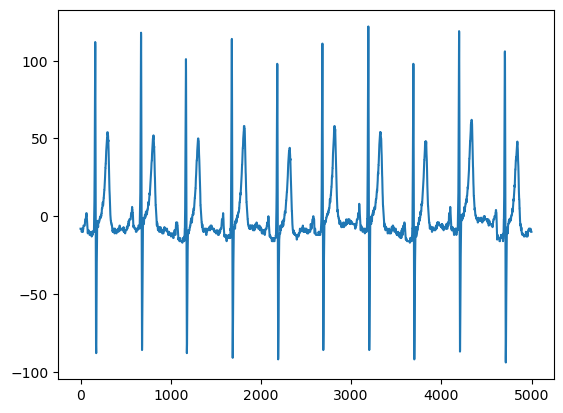

In [91]:
caseid = 'ecg_child_8782'
ADULT = 'child'
file_path = f'dataset/ECG_{ADULT}_numpy_valid'
seg_ecg = np.load(f'{file_path}/{caseid}.npy')

plt.plot(seg_ecg[5000*0:5000*1])

# Validation

In [6]:
SRATE = 500
TRAIN = 'train'
ADULT = 'adult'
NORM = 'z-norm'
LEADS = np.arange(12)
ECG_FILT = 'bandpass'

df_sub = pd.read_csv(f'ECG_{ADULT}_age_{TRAIN}.csv')
for idx, row in tqdm(df_sub.iterrows(), total=df_sub.shape[0]):
    if 'adult' in row['FILENAME']:
        ADULT = 'adult'
        model = model_adult_male if row['GENDER'] == 'MALE' else model_adult_female
    else:
        ADULT = 'child'
        model = model_child_male if row['GENDER'] == 'MALE' else model_child_female
          
    file_path = f'dataset/ECG_{ADULT}_numpy_{TRAIN}'
    caseid = row['FILENAME']
    
    seg_ecg = np.load(f'{file_path}/{caseid}.npy')
    seg_ecg = ECG_filter(pd.DataFrame(seg_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten(), method=ECG_FILT, srate=SRATE)
    
    # invalid ecg
    if len(np.unique(seg_ecg)) == 1:
        df_sub.loc[idx, 'AGE'] = 65 if ADULT == 'adult' else 4
        continue
    
    # NORM = z-norm
    ecg_input = []
    for i in LEADS:
        ecg_input.append(stats.zscore(seg_ecg[5000*i:5000*(i+1)]))

    df_sub.loc[idx, 'AGE'] = model.predict(np.array(ecg_input).reshape(1,12,5000).transpose((0,2,1)), verbose=0).flatten()[0]   

  0%|          | 0/34907 [00:00<?, ?it/s]2023-09-21 01:17:01.744623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8904
2023-09-21 01:17:02.792966: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-21 01:17:02.929098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
  1%|          | 282/34907 [00:27<56:30, 10.21it/s]  

KeyboardInterrupt

